## Business Case:

Based on given data on domestic flights,Create a predictive model which will help the customers to predict future flight prices and plan their journey accordingly.

In [1]:
#Importing basic libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the csv file
data=pd.read_csv('Flight_Fare.csv')
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## BASIC CHECKS

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [4]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


* This statistics show that the least price paid by the customers is 1,759 and the highest fare has been 79,512.
* Half of the customers has paid below 8,372 for their flights.
* The average value of the fares is about 9,000. 

## DATA CLEANING

### Handling missing values

In [5]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
# Find data with missing values
data[data.isnull().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [7]:
# Find flights from Delhi to Cochin at the same time period with the same price
data.loc[(data.Source=='Delhi')&(data.Destination=='Cochin')&(data.Airline=='Air India')&(data.Price==7480)&(data.Duration=='23h 40m')]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
1616,Air India,24/05/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 25 May,23h 40m,1 stop,No info,7480
2554,Air India,15/05/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 16 May,23h 40m,1 stop,No info,7480
4351,Air India,27/06/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 28 Jun,23h 40m,1 stop,No info,7480
7896,Air India,12/06/2019,Delhi,Cochin,DEL → MAA → COK,09:45,09:25 13 Jun,23h 40m,1 stop,No info,7480
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [8]:
data.loc[data.Route.isnull(),['Route']]='DEL → MAA → COK'
data.loc[data.Total_Stops.isnull(),['Total_Stops']]='1 stop'
#Thus missing values are handled.

### Fixing Structural Error

In [9]:
data.Destination.unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [10]:
# New Delhi and Delhi airports are both the same,merging them into one.
data.Destination=data.Destination.replace('New Delhi','Delhi')

# Categorize business class tickets into a 'Class' column.
# Prices above 30,000 can be considered as a business class ticket for domestic flights.
data.loc[(data.Airline=='Jet Airways Business')|(data.Price>30000),'Class']='Business_Class'

# Create a new variable in 'Class' column.
data.loc[(data.Airline.isin(['Multiple carriers Premium economy','Vistara Premium economy'])),'Class']='Premium_Economy'

In [11]:
# Function to convert duration to minutes
import regex as re
def convert_duration_to_minutes(duration):
    hours = 0
    minutes = 0
    if 'h' in duration:
        h = re.search(r'(\d+)h', duration)
        if h:
            hours = int(h.group(1))
    if 'm' in duration:
        m = re.search(r'(\d+)m', duration)
        if m:
            minutes = int(m.group(1))
    return hours * 60 + minutes

# Apply conversion
data['Duration_Minutes'] = data['Duration'].apply(convert_duration_to_minutes)

In [12]:
# Check for errors in duration with respect to the departure and arrival times.
from datetime import datetime, timedelta

# Function to compute elapsed time in minutes
def compute_elapsed_minutes(dep_time, arr_time, journey_date):
    try:
        # Parse departure time
        dep_dt = datetime.strptime(journey_date + " " + dep_time, "%d/%m/%Y %H:%M")

        # Try to parse arrival time (with or without date)
        try:
            arr_dt = datetime.strptime(arr_time, "%H:%M %d %b")
            arr_dt = arr_dt.replace(year=dep_dt.year)
        except:
            arr_dt = datetime.strptime(journey_date + " " + arr_time, "%d/%m/%Y %H:%M")
            if arr_dt < dep_dt:
                arr_dt += timedelta(days=1)

        return (arr_dt - dep_dt).total_seconds() / 60
    except:
        return None

# Calculate elapsed minutes for each row
data['Elapsed_Minutes'] = data.apply(lambda row: compute_elapsed_minutes(row['Dep_Time'], row['Arrival_Time'], row['Date_of_Journey']), axis=1)

# Compare with existing Duration_Minutes (tolerance = 10 minutes)
data['Duration_Error'] = abs(data['Duration_Minutes'] - data['Elapsed_Minutes']) > 10

# Filter and display rows with mismatched durations
errors = data[data['Duration_Error']]
errors[['Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration', 'Duration_Minutes', 'Elapsed_Minutes']]

,Date_of_Journey,Dep_Time,Arrival_Time,Duration,Duration_Minutes,Elapsed_Minutes
0,24/03/2019,22:20,01:10 22 Mar,2h 50m,170,-4150.0
21,21/03/2019,22:00,13:20 19 Mar,15h 20m,920,-3400.0
52,24/03/2019,22:20,01:10 28 Mar,2h 50m,170,4490.0
71,09/03/2019,05:45,08:15 13 Mar,26h 30m,1590,5910.0
110,18/03/2019,14:05,05:05 16 Mar,15h,900,-3420.0
...,...,...,...,...,...,...
10441,18/03/2019,11:40,08:15 16 Mar,20h 35m,1235,-3085.0
10489,15/03/2019,22:05,00:30 13 Mar,2h 25m,145,-4175.0
10590,24/03/2019,23:25,02:10 22 Mar,2h 45m,165,-4155.0
10638,21/03/2019,21:25,11:25 19 Mar,14h,840,-3480.0


In [13]:
# Correct the errors in Dep_Time and Arrival_Time
def clean_time_string(time_str):
    try:
        return datetime.strptime(time_str.strip(), "%H:%M").strftime("%H:%M")
    except:
        return None

data['Dep_Time'] = data['Dep_Time'].apply(clean_time_string)
data['Arrival_Time'] = data['Arrival_Time'].apply(clean_time_string)

In [14]:
# Compute elapsed minutes
def compute_elapsed_minutes(dep_time, arr_time, journey_date):
    try:
        dep_dt = datetime.strptime(journey_date + " " + dep_time, "%d/%m/%Y %H:%M")
        arr_dt = datetime.strptime(journey_date + " " + arr_time, "%d/%m/%Y %H:%M")
        if arr_dt < dep_dt:
            arr_dt += timedelta(days=1)
        return round((arr_dt - dep_dt).total_seconds() / 60)
    except:
        return None

data['Elapsed_Minutes'] = data.apply(
    lambda row: compute_elapsed_minutes(row['Dep_Time'], row['Arrival_Time'], row['Date_of_Journey']),
    axis=1)
# Change Duration Minutes accordingly
data['Duration_Minutes'] = data.apply(
    lambda row: row['Elapsed_Minutes']
    if pd.notnull(row['Elapsed_Minutes']) and abs(row['Duration_Minutes'] - row['Elapsed_Minutes']) > 10
    else row['Duration_Minutes'],
    axis=1)

In [15]:
# Apply the change to Duration
def format_duration(minutes):
    if pd.isnull(minutes):
        return None
    h = int(minutes) // 60
    m = int(minutes) % 60
    return (f"{h}h " if h else "") + (f"{m}m" if m else "")

data['Duration'] = data['Duration_Minutes'].apply(format_duration)

In [16]:
# View the changes
data[['Dep_Time', 'Arrival_Time', 'Duration', 'Duration_Minutes', 'Elapsed_Minutes']].head(10)

,Dep_Time,Arrival_Time,Duration,Duration_Minutes,Elapsed_Minutes
0,22:20,None,2h 50m,170.0,NaN
1,05:50,13:15,7h 25m,445.0,445.0
2,09:25,None,19h,1140.0,NaN
3,18:05,23:30,5h 25m,325.0,325.0
4,16:50,21:35,4h 45m,285.0,285.0
5,09:00,11:25,2h 25m,145.0,145.0
6,18:55,None,15h 30m,930.0,NaN
7,08:00,None,21h 5m,1265.0,NaN
8,08:55,None,25h 30m,1530.0,NaN
9,11:25,19:15,7h 50m,470.0,470.0


In [17]:
data.Arrival_Time.isnull().sum()

np.int64(4335)

In [18]:
# There are 4335 arrival times missing

# Helper: Convert '2h 50m' → timedelta
def parse_duration(duration_str):
    hours = minutes = 0
    if 'h' in duration_str:
        hours = int(duration_str.split('h')[0].strip())
        duration_str = duration_str.split('h')[1]
    if 'm' in duration_str:
        minutes = int(duration_str.strip().replace('m', ''))
    return timedelta(hours=hours, minutes=minutes)

# Compute Arrival_Time from Dep_Time + Duration
def compute_arrival_time(row):
    try:
        dep_dt = datetime.strptime(row['Date_of_Journey'] + " " + row['Dep_Time'], "%d/%m/%Y %H:%M")
        duration = parse_duration(row['Duration'])
        arrival_dt = dep_dt + duration
        return arrival_dt.strftime("%H:%M %d %b")  # match original format
    except:
        return None  # in case of format errors or missing values

# Apply to missing Arrival_Times only
data['Arrival_Time'] = data.apply(
    lambda row: compute_arrival_time(row) if pd.isna(row['Arrival_Time']) or row['Arrival_Time'] == '' else row['Arrival_Time'],
    axis=1)

In [19]:
# The minimum duration for a flight from mumbai to hyderabad is 1 hour 15 mins(75 min).
# Check for flights with duration less than that.
data.loc[(data.Duration_Minutes<75)&(data.Source=='Mumbai')]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Class,Duration_Minutes,Elapsed_Minutes,Duration_Error
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2 stops,No info,17327,NaN,5.0,5.0,False


In [20]:
# Duration of 5 minutes not possible at all.
# Find the mode value of duration for Air india flights from Mumbai with  two stops.
data.loc[(data.Source=='Mumbai')&(data.Total_Stops=='2 stops')&(data.Airline=='Air India')&(data.Route=='BOM → GOI → PNQ → HYD')&(data.Price==17327)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Class,Duration_Minutes,Elapsed_Minutes,Duration_Error
5309,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,21:10,16:55,19h 45m,2 stops,No info,17327,NaN,1185.0,1185.0,True
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2 stops,No info,17327,NaN,5.0,5.0,False


In [21]:
#replace 5 minutes 19h 45m.
data.iloc[6474,7]='19h 45m'
#Also replace duration minutes to 1185
data.iloc[6474,12]=1185
#And departure time accordingly
data.iloc[6474,5]='21:10'
#View the changes
data.iloc[6474]

Airline                         Air India
Date_of_Journey                 6/03/2019
Source                             Mumbai
Destination                     Hyderabad
Route               BOM → GOI → PNQ → HYD
Dep_Time                            21:10
Arrival_Time                        16:55
Duration                          19h 45m
Total_Stops                       2 stops
Additional_Info                   No info
Price                               17327
Class                                 NaN
Duration_Minutes                   1185.0
Elapsed_Minutes                       5.0
Duration_Error                      False
Name: 6474, dtype: object

In [22]:
data.Source.unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [23]:
data.loc[(data.Source=='Mumbai'),'Destination'].value_counts()

Destination
Hyderabad    697
Name: count, dtype: int64

In [24]:
# Check for flights from Mumbai with 2 stops having duration less than 6 hours(Average time).
data.loc[(data.Total_Stops=='2 stops')&(data.Source=='Mumbai')&(data.Duration_Minutes<=360)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Class,Duration_Minutes,Elapsed_Minutes,Duration_Error
8478,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,13:30,16:55,3h 25m,2 stops,No info,18797,NaN,205.0,205.0,False


In [25]:
# Check duration of flights in the same route.
data.loc[data.Route=='BOM → GOI → PNQ → HYD']

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Class,Duration_Minutes,Elapsed_Minutes,Duration_Error
3821,Air India,12/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,21:10,16:55,19h 45m,2 stops,No info,16172,NaN,1185.0,1185.0,True
5309,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,21:10,16:55,19h 45m,2 stops,No info,17327,NaN,1185.0,1185.0,True
5942,Air India,12/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,05:05,16:55,11h 50m,2 stops,No info,16172,NaN,710.0,710.0,False
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,21:10,16:55,19h 45m,2 stops,No info,17327,NaN,1185.0,5.0,False
7456,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,05:05,16:55,11h 50m,2 stops,No info,16697,NaN,710.0,710.0,False
8478,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,13:30,16:55,3h 25m,2 stops,No info,18797,NaN,205.0,205.0,False


In [26]:
# There is no matching results with the price.
# Replace the duration minutes with the mode(1185).
data.iloc[8478,12]=1185.0
# Replace Duration accordingly
data.iloc[8478,7]='19h 45m'
# Also replace the dep_time
data.iloc[8478,5]='21:10'
# View the changes
data.iloc[8478]

Airline                         Air India
Date_of_Journey                 6/03/2019
Source                             Mumbai
Destination                     Hyderabad
Route               BOM → GOI → PNQ → HYD
Dep_Time                            21:10
Arrival_Time                        16:55
Duration                          19h 45m
Total_Stops                       2 stops
Additional_Info                   No info
Price                               18797
Class                                 NaN
Duration_Minutes                   1185.0
Elapsed_Minutes                     205.0
Duration_Error                      False
Name: 8478, dtype: object

## FEATURE ENGINEERING

In [27]:
# Create two new columns for the hour of the departure and arrival
data['Dep_Hour'] = pd.to_datetime(data['Dep_Time']).dt.hour
data['Arr_Hour'] = pd.to_datetime(data['Arrival_Time']).dt.hour

# Create new columns such as day,month and weekday of the journey
# This will help to find if there is relationship between specific days of the week or month.
data['Journey_Date'] = pd.to_datetime(data['Date_of_Journey'])
data['Journey_Day'] = data['Journey_Date'].dt.day
data['Journey_Month'] = data['Journey_Date'].dt.month
data['Journey_Weekday'] = data['Journey_Date'].dt.dayofweek    #0:monday....6:Sunday

# Convert Duration to categories such as 'within 3hrs','3-6hrs',....'above 24hrs'

# Define bins (in minutes)
bins = [0, 180, 360, 540 , 720, 900, 1080, 1260, 1440, float('inf')]
labels = [
    'Within 3 hours',
    '3–6 hours',
    '6-9 hours',
    '9–12 hours',
    '12–15 hours',
    '15-18 hours',
    '18–21 hours',
    '21-24 hours',
    'Above 24 hours']

# Categorize durations
data['Duration_cat'] = pd.cut(data['Duration_Minutes'], bins=bins, labels=labels, right=False)

# Flights with atleast one stop can be considered as layover flights.
# Give the value as layover flights for the flights that are not 'non-stop'
data['Is_Layover_Flight']=(data.Total_Stops!='non-stop').astype(int)

In [28]:
# Add these to the red-eye-flights category
data['Red_eye_Flight']=((data.Dep_Hour.isin([21,22,23,0,1]))&(data.Arr_Hour.isin([2,3,4,5,6]))).astype(int)

In [29]:
# Check the maximum price of a flight which is not a premium economy or a business class. 
data.loc[(data.Class!='Premium_Economy')&(data.Class!='Business_Class'),'Price'].max()

29528

In [30]:
# It is very high.Let's check flights greater than 25,000 and below 29528.
pd.set_option('display.max_columns',None)
data.loc[(data.Price<=29528)&(data.Price>25000)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Class,Duration_Minutes,Elapsed_Minutes,Duration_Error,Dep_Hour,Arr_Hour,Journey_Date,Journey_Day,Journey_Month,Journey_Weekday,Duration_cat,Is_Layover_Flight,Red_eye_Flight
123,Air India,1/03/2019,Delhi,Cochin,DEL → BOM → COK,23:00,19:15 02 Mar,20h 15m,1 stop,No info,27430,NaN,1215.0,NaN,False,23,19,2019-03-01,1,3,4,18–21 hours,1,0
486,Jet Airways,01/03/2019,Banglore,Delhi,BLR → BOM → DEL,08:55,15:15,6h 20m,1 stop,No info,26890,NaN,380.0,380.0,False,8,15,2019-03-01,1,3,4,6-9 hours,1,0
510,Jet Airways,01/03/2019,Banglore,Delhi,BLR → BOM → DEL,07:00,12:25,5h 25m,1 stop,No info,26890,NaN,325.0,325.0,False,7,12,2019-03-01,1,3,4,3–6 hours,1,0
597,Air India,6/03/2019,Mumbai,Hyderabad,BOM → JDH → DEL → HYD,09:40,15:15 07 Mar,29h 35m,2 stops,No info,25139,NaN,1775.0,NaN,False,9,15,2019-03-06,6,3,2,Above 24 hours,1,0
628,Jet Airways,15/03/2019,Banglore,Delhi,BLR → BOM → DEL,22:55,05:05 16 Mar,6h 10m,1 stop,No info,27210,NaN,370.0,NaN,True,22,5,2019-03-15,15,3,4,6-9 hours,1,1
785,Air India,01/03/2019,Banglore,Delhi,BLR → BOM → BHO → DEL,08:50,23:25,14h 35m,2 stops,1 Short layover,26743,NaN,875.0,875.0,False,8,23,2019-03-01,1,3,4,12–15 hours,1,0
826,Jet Airways,01/03/2019,Banglore,Delhi,BLR → BOM → DEL,05:45,16:10,10h 25m,1 stop,No info,26890,NaN,625.0,625.0,False,5,16,2019-03-01,1,3,4,9–12 hours,1,0
936,Jet Airways,01/03/2019,Banglore,Delhi,BLR → BOM → DEL,22:50,19:10 02 Mar,20h 20m,1 stop,No info,25735,NaN,1220.0,NaN,False,22,19,2019-03-01,1,3,4,18–21 hours,1,0
946,Jet Airways,01/03/2019,Banglore,Delhi,BLR → BOM → DEL,05:45,19:10,13h 25m,1 stop,No info,27992,NaN,805.0,805.0,False,5,19,2019-03-01,1,3,4,12–15 hours,1,0
959,Jet Airways,01/03/2019,Banglore,Delhi,BLR → BOM → DEL,11:40,00:45 02 Mar,13h 5m,1 stop,No info,26890,NaN,785.0,NaN,False,11,0,2019-03-01,1,3,4,12–15 hours,1,0


In [31]:
# It is unusual for direct flights from banglore to delhi to cost more than 25,000 unless it is a business class ticket.
data.loc[(data.Price<=29528)&(data.Price>25000)&(data.Total_Stops=='non-stop'),'Class']='Business_Class'
# Rest of the connecting flights can be considered as 'Premium_economy' considering the fares.
data.loc[(data.Price<=29528)&(data.Price>25000)&(data.Total_Stops!='non-stop'),'Class']='Premium_Economy'
# The rest can be considered as economy tickets.
data.loc[(data.Class!='Business_Class')&(data.Class!='Premium_Economy'),'Class']='Economy'

In [32]:
data.Class.value_counts()

Class
Economy            10585
Premium_Economy       72
Business_Class        26
Name: count, dtype: int64

In [33]:
data.Route.value_counts()

Route
DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: count, Length: 128, dtype: int64

In [34]:
# We have 128 different routes which will be difficult in encoding.
# Convert them into main routes by avoiding the stops.
# The data already contains seperate column for the total stops.
def main_route(route):
    stops = route.split(' → ')
    return f"{stops[0]}_{stops[-1]}"

data['Route'] = data['Route'].apply(main_route)

In [35]:
# Take a look into the total stops
data.Total_Stops.value_counts()

Total_Stops
1 stop      5626
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [36]:
#T here is only 1 data on 4 stops which is very less in a data of above 10,000 entries.
# Check if we can merge both 3 stops and 4 stops into one.
data.loc[(data.Total_Stops=='3 stops')|(data.Total_Stops=='4 stops')]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Class,Duration_Minutes,Elapsed_Minutes,Duration_Error,Dep_Hour,Arr_Hour,Journey_Date,Journey_Day,Journey_Month,Journey_Weekday,Duration_cat,Is_Layover_Flight,Red_eye_Flight
402,Air India,15/06/2019,Delhi,Cochin,DEL_COK,05:15,07:40 16 Jun,26h 25m,3 stops,No info,10493,Economy,1585.0,NaN,False,5,7,2019-06-15,15,6,5,Above 24 hours,1,0
919,Air India,12/05/2019,Kolkata,Banglore,CCU_BLR,12:00,23:15 13 May,35h 15m,3 stops,No info,10991,Economy,2115.0,NaN,False,12,23,2019-05-12,12,5,6,Above 24 hours,1,0
1218,Air India,27/06/2019,Delhi,Cochin,DEL_COK,05:15,07:40 28 Jun,26h 25m,3 stops,No info,11543,Economy,1585.0,NaN,False,5,7,2019-06-27,27,6,3,Above 24 hours,1,0
1665,Air India,01/03/2019,Banglore,Delhi,BLR_DEL,05:50,12:15 02 Mar,30h 25m,3 stops,No info,12346,Economy,1825.0,NaN,False,5,12,2019-03-01,1,3,4,Above 24 hours,1,0
2172,Air India,18/05/2019,Delhi,Cochin,DEL_COK,05:15,19:15 19 May,38h,3 stops,No info,10703,Economy,2280.0,NaN,False,5,19,2019-05-18,18,5,5,Above 24 hours,1,0
2623,Air India,12/03/2019,Mumbai,Hyderabad,BOM_HYD,09:40,15:15 13 Mar,29h 35m,3 stops,No info,18293,Economy,1775.0,NaN,False,9,15,2019-03-12,12,3,1,Above 24 hours,1,0
2633,Multiple carriers,6/03/2019,Delhi,Cochin,DEL_COK,11:35,21:00,9h 25m,3 stops,No info,21829,Economy,565.0,565.0,False,11,21,2019-03-06,6,3,2,9–12 hours,1,0
2718,Air India,9/03/2019,Delhi,Cochin,DEL_COK,05:15,19:15 10 Mar,38h,3 stops,No info,15586,Economy,2280.0,NaN,False,5,19,2019-03-09,9,3,5,Above 24 hours,1,0
2814,Air India,12/03/2019,Banglore,Delhi,BLR_DEL,17:25,18:05 13 Mar,24h 40m,3 stops,No info,13387,Economy,1480.0,NaN,False,17,18,2019-03-12,12,3,1,Above 24 hours,1,0
2822,Air India,24/05/2019,Kolkata,Banglore,CCU_BLR,10:00,10:30 25 May,24h 30m,3 stops,No info,13007,Economy,1470.0,NaN,False,10,10,2019-05-24,24,5,4,Above 24 hours,1,0


In [37]:
# Prices and duration of 4 stops doesn't seem to be very different from data with 3 stops.
# Merge both into one column named 'More than 3 stops'
data.loc[(data.Total_Stops=='3 stops')|(data.Total_Stops=='4 stops'),'Total_Stops']='More than 3 stops'

# Convert total stops to a numerical column.
data.Total_Stops=data.Total_Stops.map({'non-stop':0,'1 stop':1,'2 stops':2,'More than 3 stops':3})

# Create two new columns for information on chech-in baggage and meals.
data.No_Check_in_baggage=(data.Additional_Info=='No check-in baggage included').astype(int)
data.No_meals=(data.Additional_Info=='In-flight meal not included').astype(int)

In [38]:
# Create two new columns named 'Dep_Period' and 'Arrival_Period' 
# by converting the time of the departure and arrival of the flight('Dep_Time','Arrival_Time') 
# to parts of a day such as morning,evening etc. 
def get_departure_period(hour):
    if 4 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    elif 20 <= hour <= 23:
        return 'Night'
    else:
        return 'Late Night'

data['Dep_Period'] = data['Dep_Hour'].apply(get_departure_period)

def get_arrival_period(hour):
    if 4 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    elif 20 <= hour <= 23:
        return 'Night'
    else:
        return 'Late Night'

data['Arrival_Period'] = data['Arr_Hour'].apply(get_arrival_period)

## Univariate Analysis

### Numerical Columns

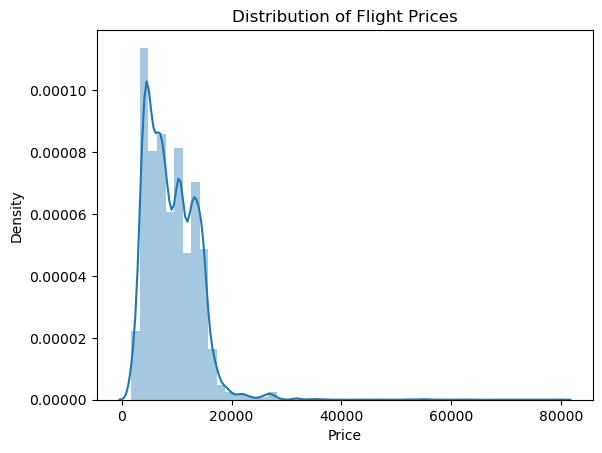

In [39]:
# Check the distribution of Price
sns.distplot(data.Price)
plt.title('Distribution of Flight Prices')
plt.show()

#### Findings
* The distribution is positively skewed(right-skewed).
* The peak is on the left side around lower price values.
* The tail stretches to the right side,towards higher prices (up to ~80000).
* In overall,most flight prices are low but a few are very high.


<Axes: xlabel='Duration_Minutes', ylabel='Count'>

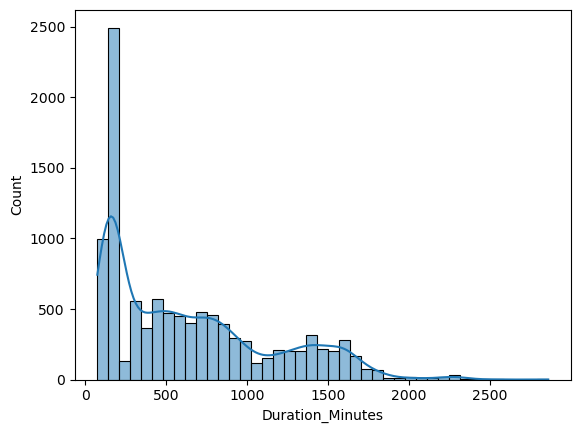

In [40]:
sns.histplot(data.Duration_Minutes,kde=True)

#### Findings
* Most of the flights takes duration of within 2-3 hours.
* There are flights with very higher duration (above 24 hours).

### Categorical columns

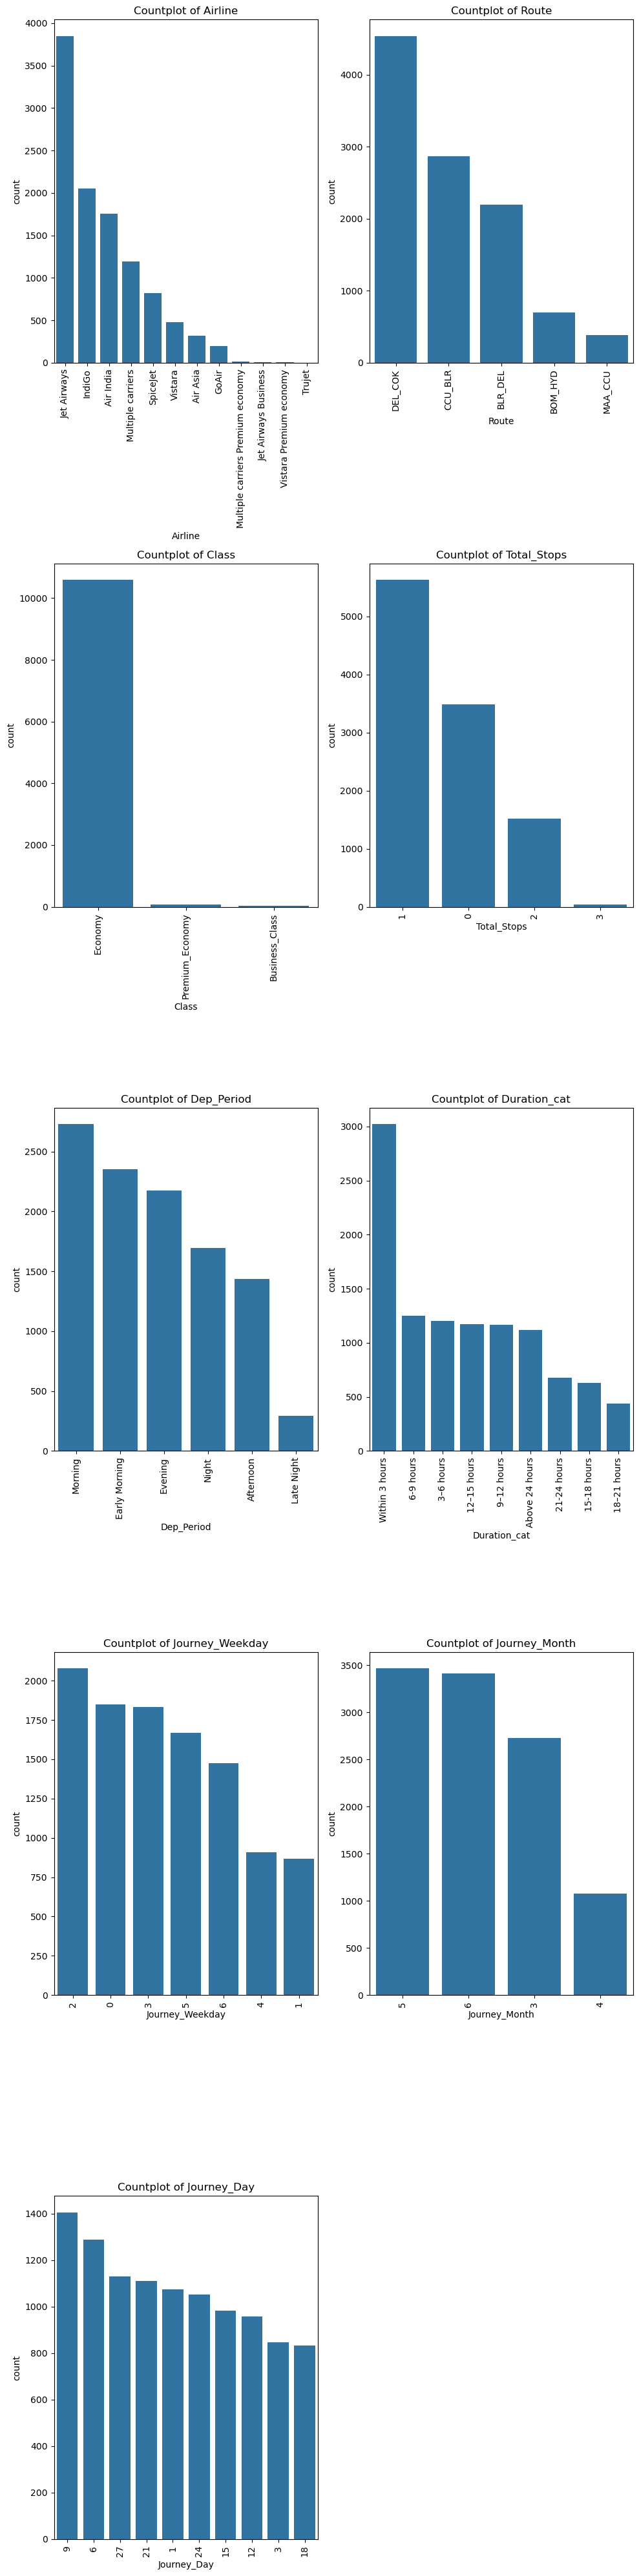

In [41]:
# List of categorical columns to plot
cols = ['Airline' ,'Route' , 'Class' , 'Total_Stops', 'Dep_Period' , 'Duration_cat' , 'Journey_Weekday' , 'Journey_Month', 'Journey_Day']

# Set number of plots per row
cols_per_row = 2
total_plots = len(cols)
rows = (total_plots + cols_per_row - 1) // cols_per_row

# Create subplots
fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 8 * rows))
axes = axes.flatten()

# Plot each countplot
for i, col in enumerate(cols):
    sns.countplot(data=data, x=col, ax=axes[i], order=data[col].value_counts().index)
    axes[i].set_title(f'Countplot of {col}')
    axes[i].tick_params(axis='x', rotation=90)

# Hide unused plots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')


plt.tight_layout()
plt.show()

#### Findings
* Jet Airways has the highest number of flights,significantly more than all other flights.
* IndiGo and Air India follows next with a strong number of entries.
* Trujet contributes the least in the data.It is almost negligible.
* Majority of the flights are in the Delhi to Cochin route(Over 4,500 flights).
* Kolkata to Banglore and  Bangalore to Delhi routes together contributes to about 50% of the data.
* Chennai to Kolkata is the route with the least data.
* Premium Economy and Business Class flights are very less in the data.
* Over 50% of the flights are connecting flights with 1 stop.
* About 3500 flights are direct flights.
* Flights with 2 stops contribute about 15% of the data.
* We have very less data on flights having more than 3 stops.
* Many of the flights departs at mornings and early mornings.
* Only less than 500 flights departs at late night.
* About 30% flights takes the least duration of within 3 hours.
* Flights with the duration above 3 hours and within 15 hours together contribute to 60% of the data.
* Wednesdays has the most number of flights(~2000).
* More than 1750 flights operates on Mondays and Thursdays.
* Weekends have above 1500 flights.
* May and June has the most number of entries(over 3400).
* March hold the third space with over 2700 entries
* The least amount of flights are in April.
* There is no special patterns in the day of the journey.
* Only 10 unique days is available in data.
* Each days have entries above 800.

### Bivariate Analysis

In [42]:
data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Class', 'Duration_Minutes',
       'Elapsed_Minutes', 'Duration_Error', 'Dep_Hour', 'Arr_Hour',
       'Journey_Date', 'Journey_Day', 'Journey_Month', 'Journey_Weekday',
       'Duration_cat', 'Is_Layover_Flight', 'Red_eye_Flight', 'Dep_Period',
       'Arrival_Period'],
      dtype='object')

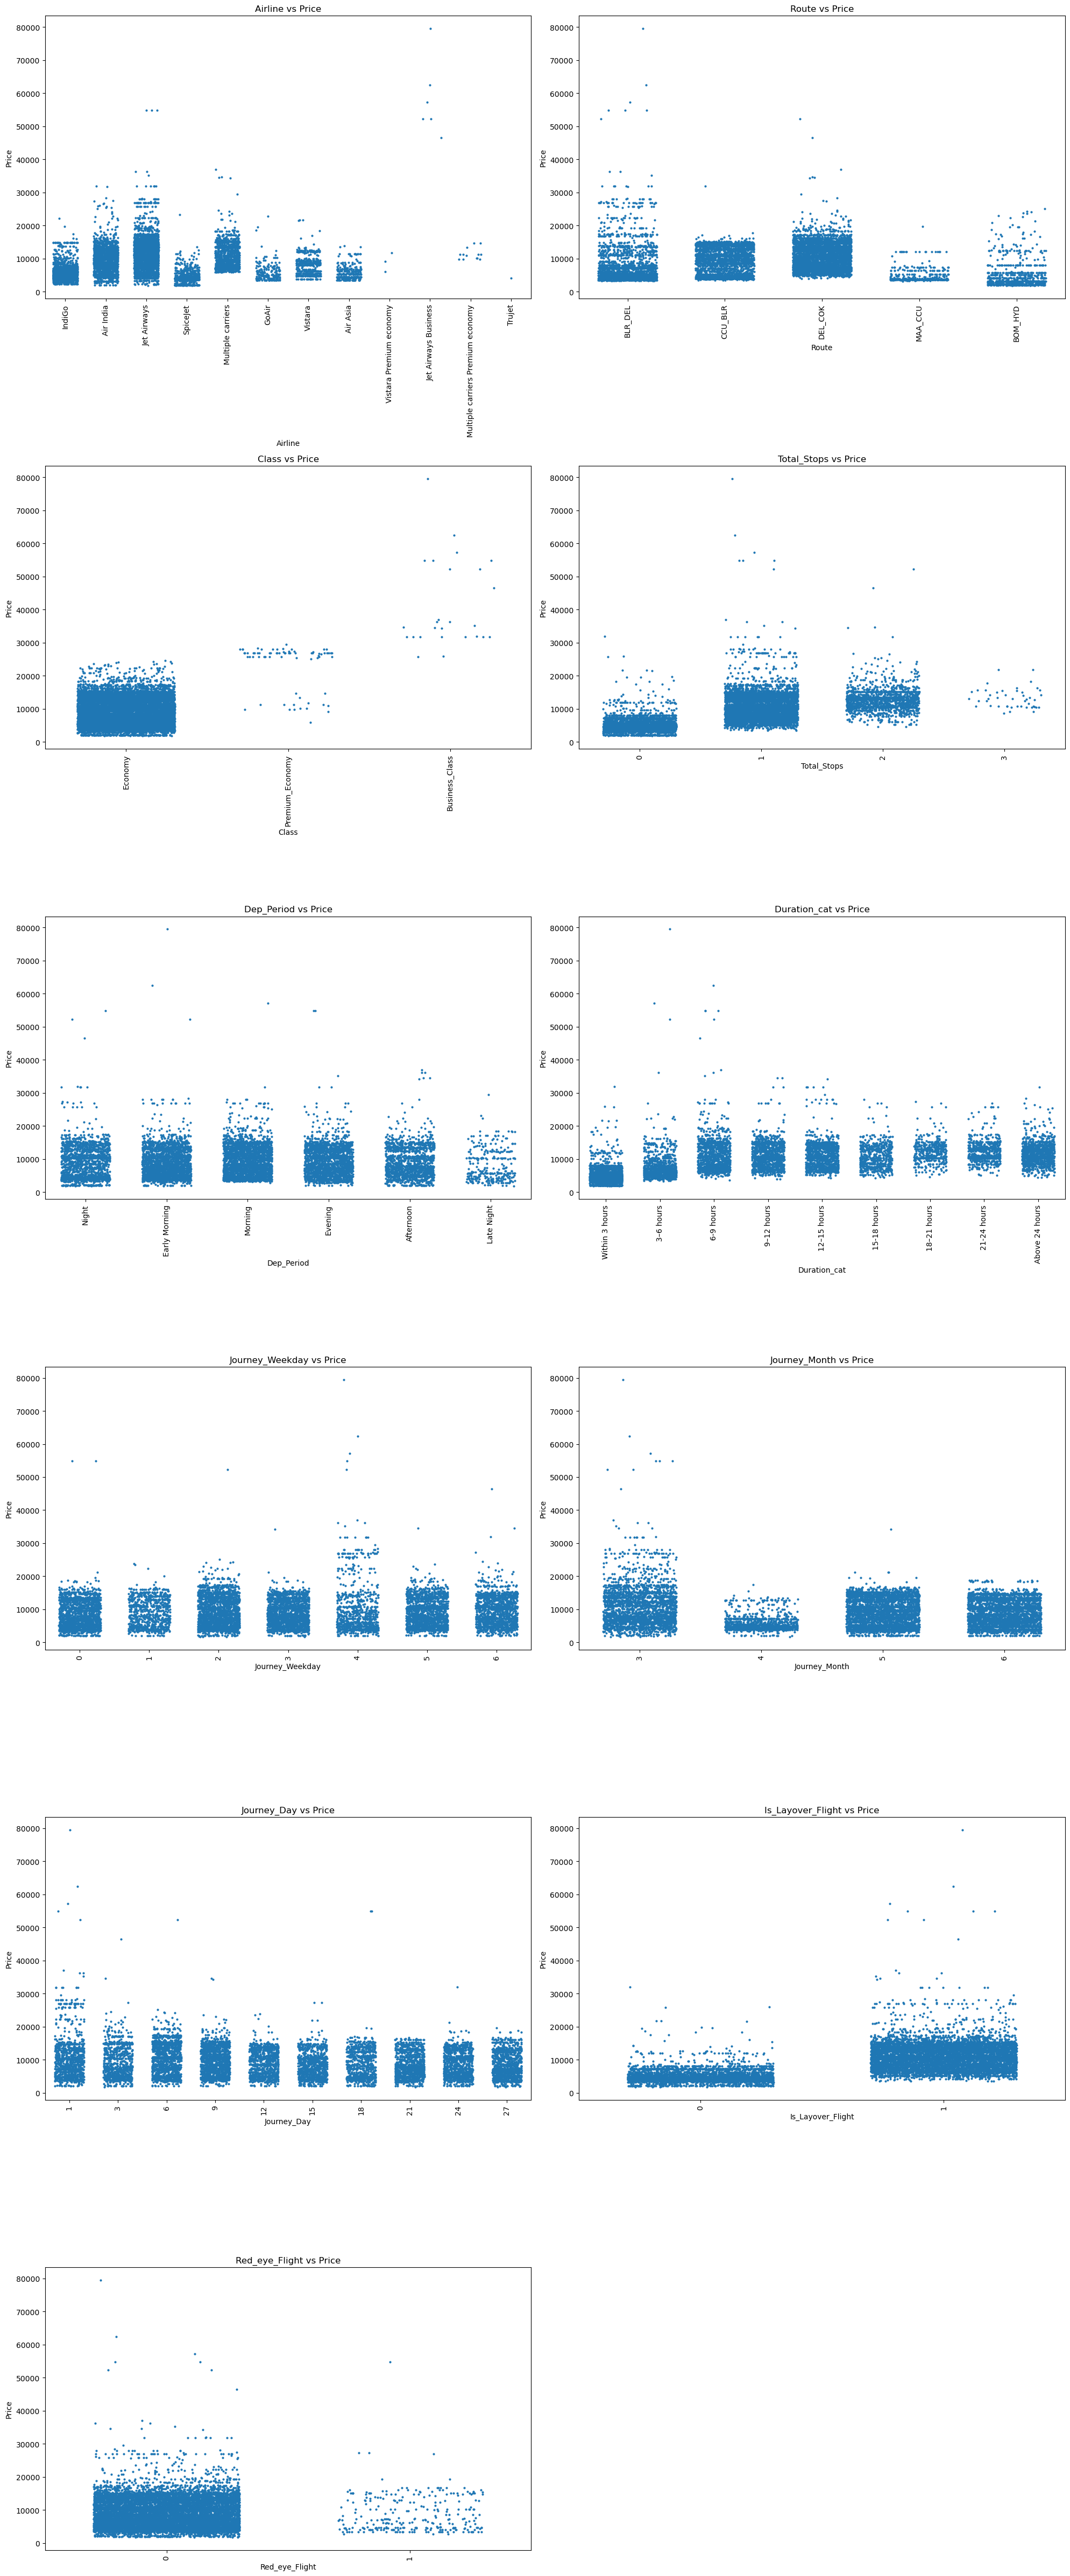

In [43]:
# List of categorical columns to plot against 'Price'
cat_cols = ['Airline' ,'Route' , 'Class' , 'Total_Stops', 'Dep_Period' , 'Duration_cat' , 'Journey_Weekday' , 'Journey_Month', 'Journey_Day' , 'Is_Layover_Flight' , 'Red_eye_Flight']

# Grid setup
cols_per_row = 2
rows = (len(cat_cols) + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(10 * cols_per_row, 8 * rows))
axes = axes.flatten()

# Loop to create strip plots
for i, col in enumerate(cat_cols):
    sns.stripplot(data=data, x=col, y='Price', ax=axes[i], jitter=0.3, size=3)
    axes[i].set_title(f'{col} vs Price')
    axes[i].tick_params(axis='x', rotation=90)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

#### Findings
* SpiceJet is a budget airlines.
* Jet airways is expensive compared to other flights.
* IndiGo and Air Asia are also better option for budget travellers.
* Chennai to Kolkata flights have the least ticket fares in general.
* Flights to every routes starts from around 5000 or below.
* Some of the flights from Bangalore to Delhi and Delhi to Cochin are really expensive(might be connecting flights or Business Class tickets).
* Charges for Mumbai to Hyderabad flights falls below 28000.
* Business Class tickets starts above 25,000.
* Premium economy tickets comes under and above 20,000.
* Most of the direct flight's prices starts from around 2,000 and comes below 10,000.
* There are some direct flights that charges between 20K to 35K.
* Ticket prices for most of the connecting flights ranges from 5,000 to 25,000.
* Domestic Layover flights costs comparitively high and can go upto very high based on other features.
* Even with 3 or 4 stops,Air India's ticket fares comes under 20000.
* Late night flights are the cheapest.
* Morning flights have the highest average prices on almost every days.
* Flight with the highest charge is an early morning flight.
* Departure period doesn't seems to affect the prices as flights from almost every periods starts around 3000.
* The prices are widely spread for journey below 12 hours means that the duration alone cannot be considered as a predictor for price.
* Some of the most expensive flights are under these 12 hours.
* Flights with duration greater than 15 hours comes in a narrower range.
* Fridays and Sundays have relatively higher charges.
* March had relatively higher charges than other months.
* Layover flights are expensive.
* Red-eye flights normally costs around 5K to 15K.
                

In [44]:
pd.crosstab(data.Airline,data['Duration_cat'])

Duration_cat,Within 3 hours,3–6 hours,6-9 hours,9–12 hours,12–15 hours,15-18 hours,18–21 hours,21-24 hours,Above 24 hours
Airline,,,,,,,,,
Air Asia,181,45,14,28,39,12,0,0,0
Air India,367,75,72,134,178,128,158,190,450
GoAir,92,37,47,18,0,0,0,0,0
IndiGo,1129,493,149,121,116,45,0,0,0
Jet Airways,356,409,478,449,505,306,280,479,587
Jet Airways Business,0,3,3,0,0,0,0,0,0
Multiple carriers,0,0,415,395,295,91,0,0,0
Multiple carriers Premium economy,0,0,5,4,3,1,0,0,0
SpiceJet,670,93,55,0,0,0,0,0,0


#### Findings
* Majority of IndiGo,SpiceJet,Vistara,GoAir and AirAsia flights takes duration within 3 hours.
* Above mentioned flights are the cheapest ones,so duration is a great factor which affects the price.
* Jet Airways and Air India,which are comparitively the expensive flights among all has 587 and 450 flights that takes above 24 hours to arrive.
* Those two and Vistara are the airlines that has flights in every durations.

In [45]:
pd.crosstab(data.Airline,data.Route)

Route,BLR_DEL,BOM_HYD,CCU_BLR,DEL_COK,MAA_CCU
Airline,,,,,
Air Asia,89,0,150,80,0
Air India,332,136,512,747,25
GoAir,93,0,25,76,0
IndiGo,523,196,445,705,184
Jet Airways,788,219,1256,1586,0
Jet Airways Business,4,0,0,2,0
Multiple carriers,0,0,0,1196,0
Multiple carriers Premium economy,0,0,0,13,0
SpiceJet,181,122,300,87,128


#### Findings
* Only Air India,IndiGo,SpiceJet and Vistara have flights operating through every routes.
* The highest number of flights is operated by Jet Airways in Delhi to Cochin route.
* Chennai to Kolkata has the least number of airlines.
* Multiple carriers(connecting flights by different airlines) only operates in Delhi to Cochin route.
* Highest number of airlines operates through this route.

In [46]:
#dropping unnecessary columns
df=data.drop(['Date_of_Journey','Dep_Time','Arrival_Time','Dep_Hour','Arr_Hour','Journey_Date','Duration_Minutes','Additional_Info','Duration_Error','Elapsed_Minutes'],axis=1)
df.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Price,Class,Journey_Day,Journey_Month,Journey_Weekday,Duration_cat,Is_Layover_Flight,Red_eye_Flight,Dep_Period,Arrival_Period
0,IndiGo,Banglore,Delhi,BLR_DEL,2h 50m,0,3897,Economy,24,3,6,Within 3 hours,0,0,Night,Late Night
1,Air India,Kolkata,Banglore,CCU_BLR,7h 25m,2,7662,Economy,1,5,2,6-9 hours,1,0,Early Morning,Afternoon


### Converting categorical variables into numerical variables.

#### 1.Airline

In [47]:
sorted_airline=sorted(df.Airline.unique())
sorted_airline

['Air Asia',
 'Air India',
 'GoAir',
 'IndiGo',
 'Jet Airways',
 'Jet Airways Business',
 'Multiple carriers',
 'Multiple carriers Premium economy',
 'SpiceJet',
 'Trujet',
 'Vistara',
 'Vistara Premium economy']

In [48]:
# Create a mapping dictionary
cat_to_num = {cat: i for i, cat in enumerate(sorted_airline)}

# Apply the mapping
df['Airline'] = df['Airline'].map(cat_to_num)

#### 2.Source

In [50]:
#Applying Label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Source'] = le.fit_transform(df['Source'])

#### 3.Destination

In [51]:
#Applying Label encoding
df['Destination'] = le.fit_transform(df['Destination'])

#### 4.Route

In [52]:
df.Route.value_counts()

Route
DEL_COK    4537
CCU_BLR    2871
BLR_DEL    2197
BOM_HYD     697
MAA_CCU     381
Name: count, dtype: int64

In [53]:
#Applying label encoding
df.Route=le.fit_transform(df['Route'])

#### 5.Duration

In [54]:
df.Duration_cat.value_counts()

Duration_cat
Within 3 hours    3022
6-9 hours         1251
3–6 hours         1201
12–15 hours       1172
9–12 hours        1165
Above 24 hours    1120
21-24 hours        680
15-18 hours        631
18–21 hours        441
Name: count, dtype: int64

In [55]:
duration_order = [
    'Within 3 hours',
    '3–6 hours',
    '6-9 hours',
    '9–12 hours',
    '12–15 hours',
    '15-18 hours',
    '18–21 hours',
    '21-24 hours',
    'Above 24 hours'
]

# Create a mapping dictionary
duration_map = {label: idx for idx, label in enumerate(duration_order)}

# Apply to the column
df['Duration'] = df['Duration_cat'].map(duration_map)

In [56]:
df.drop('Duration_cat',axis=1,inplace=True)

#### 6.Dep_Period

In [57]:
df.Dep_Period.value_counts()

Dep_Period
Morning          2729
Early Morning    2353
Evening          2177
Night            1693
Afternoon        1436
Late Night        295
Name: count, dtype: int64

In [58]:
time_order = {
    'Early Morning': 1,
    'Morning': 2,
    'Afternoon': 3,
    'Evening': 4,
    'Night': 5,
    'Late Night': 6}

df['Dep_Period'] = df['Dep_Period'].map(time_order)

#### 7.Arrival_Period

In [59]:
df['Arrival_Period'] = df['Arrival_Period'].map(time_order)

#### 8.Class

In [60]:
df.Class.value_counts()

Class
Economy            10585
Premium_Economy       72
Business_Class        26
Name: count, dtype: int64

In [61]:
#One Hot encoding
df = pd.get_dummies(df, columns=['Class']).astype(int)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Airline                10683 non-null  int64
 1   Source                 10683 non-null  int64
 2   Destination            10683 non-null  int64
 3   Route                  10683 non-null  int64
 4   Duration               10683 non-null  int64
 5   Total_Stops            10683 non-null  int64
 6   Price                  10683 non-null  int64
 7   Journey_Day            10683 non-null  int64
 8   Journey_Month          10683 non-null  int64
 9   Journey_Weekday        10683 non-null  int64
 10  Is_Layover_Flight      10683 non-null  int64
 11  Red_eye_Flight         10683 non-null  int64
 12  Dep_Period             10683 non-null  int64
 13  Arrival_Period         10683 non-null  int64
 14  Class_Business_Class   10683 non-null  int64
 15  Class_Economy          10683 non-nul

### Correlation Plot

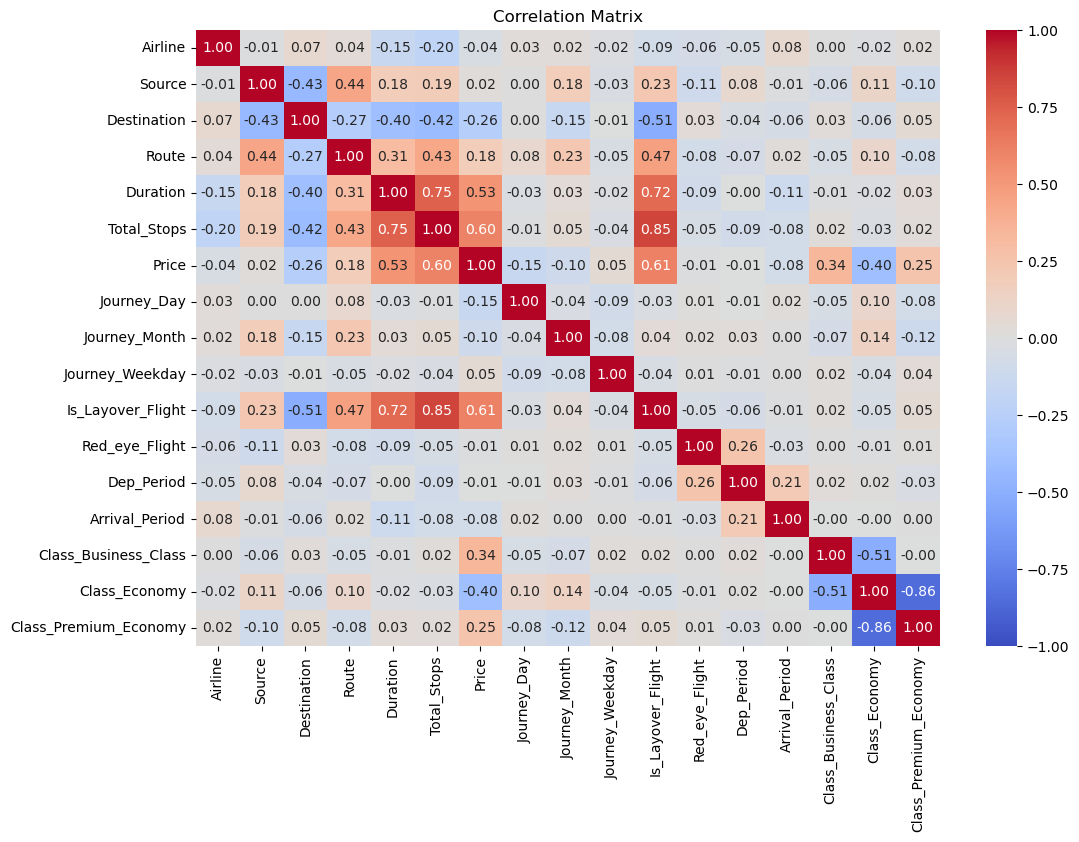

In [63]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

#### There is no high correlation(>90) between any features.

## Separate features and target


In [64]:
X = df.drop('Price', axis=1)   # Features
y = df['Price']                # Target

## Train-Test Split

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building

In [66]:
# Initialize and train Linear Regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, np.log(y_train))  #Applying log on the prices.


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [67]:
# Make predictions
y_pred1 = lr.predict(X_test)
y_pred_lr = np.exp(y_pred1)  # Inverse transform

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_lr)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_lr)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 9119504.71
Root Mean Squared Error (RMSE): 3019.85
R-squared (R²): 0.5691


#### Inference
* The model explains only 56.941% of the variance in price.
* This means 43% of the variability in the target is not captured by the model.
* On average, the model’s predictions are off by about ₹3,019.
* Clearly,linear regression is a bad choice for this data.
* Try non-linear models.

In [68]:
# Initialize and train Random forest model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, np.log(y_train))  #Applying log on the prices.


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [69]:
#Make predictions
y_pred2 = rf.predict(X_test)
y_pred_rf = np.exp(y_pred2)  # Inverse transform

#Evaluate the model
mse = mean_squared_error(y_test, y_pred_rf)
rmse = mse ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

print("R² Score (Random Forest):", r2_rf)

Mean Squared Error (MSE): 3862147.08
Root Mean Squared Error (RMSE): 1965.23
R² Score (Random Forest): 0.8175130755019798


#### Inference
* Random Forest explains 81.75% of the variance in the target.
* On average, predictions deviate by ₹1,965 from the true values.
* This is clearly a better model compared to Linear regression.
* Try tuning for better results.

In [70]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']}

search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=3, n_iter=20, scoring='neg_mean_squared_error', n_jobs=-1)
search.fit(X_train, y_train)

print("Best Params:", search.best_params_)


Best Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


In [71]:
# Initialize and train Random forest model

rf1 = RandomForestRegressor(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=None,random_state=42)
rf1.fit(X_train, np.log(y_train))  #Applying log on the prices.


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
y_pred3 = rf1.predict(X_test)
y_pred_rf1 = np.exp(y_pred3)  # Inverse transform

#Evaluate the model
mse = mean_squared_error(y_test, y_pred_rf1)
rmse = mse ** 0.5
r2_rf1 = r2_score(y_test, y_pred_rf1)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

print("R² Score (Random Forest):", r2_rf1)

Mean Squared Error (MSE): 3780371.82
Root Mean Squared Error (RMSE): 1944.32
R² Score (Random Forest): 0.821376966515903


#### Inference

* The gains are modest, which is expected when the base model is already strong.
* The RMSE has slightly dropped, indicating improved accuracy.

In [73]:
# Perform Cross Validation on random forest model.
from sklearn.model_selection import cross_val_score

# Perform 5-Fold Cross Validation with R² scoring
scores = cross_val_score(rf1, X, y, cv=5, scoring='r2')

print("Cross-Validation R² Scores:", scores)
print("Mean R²:", np.mean(scores))
print("Standard Deviation:", np.std(scores))

Cross-Validation R² Scores: [0.8403609  0.81755677 0.82227029 0.82048388 0.81456541]
Mean R²: 0.8230474502413075
Standard Deviation: 0.009044601145895047


#### Inference

* Model is capturing about 81–84% of the variance in the target variable on different validation folds.
* On average, the model explains ~82% of the variance, suggesting a strong model performance.
* Standard Deviation is low, indicating that the model performs consistently across folds, with little variation between the different training/validation splits.


In [75]:
# Initialize and train XGBoosting model
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, (np.log(y_train)))

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [76]:
# Make predictions
y_pred4= xgb.predict(X_test)
y_pred_xgb = np.exp(y_pred4)  # Inverse transform
y_pred_xgb

array([12764.145 ,  6298.525 , 13130.746 , ...,  7653.5034,  4738.7183,
       12357.33  ], shape=(2137,), dtype=float32)

In [77]:
#Evaluate the model
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = mse ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("R² Score (XGBoost):", r2_xgb)

Mean Squared Error (MSE): 3356551.25
Root Mean Squared Error (RMSE): 1832.09
R² Score (XGBoost): 0.841402530670166


#### Inference

* RMSE is lowest — average prediction error is now ~1,832 rupees.
* R² of 0.841 means it explains 84.1% of price variance, which is excellent for real-world price prediction.
* The boost from Random Forest to XGBoost is significant — a ~6% drop in MSE and ~0.02 gain in R².
* Considering the ticket price range (₹1,700 to ₹75,000), an RMSE of ~₹1,832 suggests moderate prediction error, but not unreasonably high.
* This is so far the best model.
* Let's try the results after tuning this model.

In [78]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50, 
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1)

random_search.fit(X_train,y_train)

print("Best Parameters:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best score: 3391791.75


In [79]:
xgb1 = XGBRegressor(colsample_bytree=0.6,reg_lambda=2, reg_alpha=0.01,learning_rate=0.05,max_depth=7,n_estimators=300,subsample=0.8,random_state=42,gamma=0,)
xgb1.fit(X_train, (np.log(y_train)))

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [80]:
# Predict and evaluate
y_pred5 = xgb1.predict(X_test)
y_pred_xgb1 = np.exp(y_pred5)  # Inverse transform

mse = mean_squared_error(y_test, y_pred_xgb1)
rmse = np.sqrt(mse)
r2_xgb1 = r2_score(y_test, y_pred_xgb1)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2_xgb1:.6f}")

Mean Squared Error (MSE): 3173816.00
Root Mean Squared Error (RMSE): 1781.52
R² Score: 0.850037


#### Inference
* An R² of 0.85 confirms that the model is doing a good job capturing the relationship between features and ticket prices.
* An RMSE of ₹1,775 is relatively small compared to the price range (₹1,700 to ₹75,000).

In [81]:
# Perform 5-fold cross-validation
scores = cross_val_score(xgb1, X, y, cv=5, scoring='r2')

# Print cross-validation R² scores
print("Cross-validation R² scores:", scores)
print("Mean R² score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation R² scores: [0.85568011 0.84078062 0.85584038 0.84559655 0.85090184]
Mean R² score: 0.8497599005699158
Standard deviation: 0.005852968559887307


#### Inference
* All R² scores are above 0.83, indicating strong predictive performance.
* Model is explaining ~85% of the variance in the target variable consistently across different folds.
* The standard deviation of 0.0069 is quite low, showing high stability and robustness across different data splits.
* This means that the model's performance is not overly sensitive to which data it's trained/validated on.
* The test R² is 0.85099, very close to the cross-validation mean of 0.8491.
* This is a strong sign of good generalization and no overfitting

# MODEL COMPARISON REPORT

### 1.Linear Regression:

* Performs poorly compared to tree-based models.
* High RMSE (~₹3,000) suggests large deviations from actual price even after log transformation.
* R² = 0.569 → explains only ~57% of variance.

### 2.Random Forest:

* Strong performance out-of-the-box.
* RMSE ~₹1,965; R² = 0.8175.
* Tuning improved performance slightly (RMSE down by ~₹21, R² ↑ to 0.8213).
* Cross-Validation shows good consistency: Mean R² = 0.8230 ± 0.0090.
* It indicates the model is stable and generalizes well.

### 3.XGBoost:

* Outperforms Random Forest in both default and tuned versions.
* Tuned XGBoost has lowest RMSE (₹1775) and highest R² (0.85).
* Cross-Validation shows excellent consistency:
Mean R² = 0.8491 ± 0.0069.


## Comments:
* XGBoost Regressor (After Tuning) is the best model.
* It delivers the most accurate and consistent results, with the lowest error and highest explanatory power.

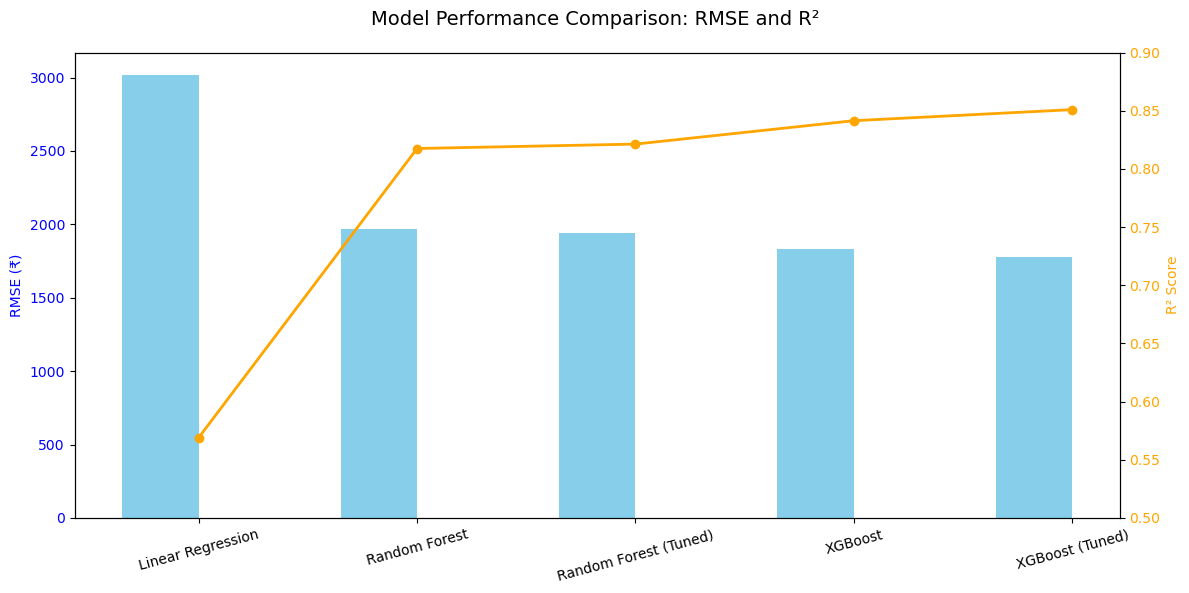

In [82]:
# Model names
models = [
    "Linear Regression",
    "Random Forest",
    "Random Forest (Tuned)",
    "XGBoost",
    "XGBoost (Tuned)"]

# RMSE values (lower is better)
rmse_values = [3019.85, 1965.23, 1944.32, 1832.09, 1775.84]

# R² values (higher is better)
r2_values = [0.5691, 0.8175, 0.8213, 0.8414, 0.8509]

# X-axis positions
x = np.arange(len(models))
width = 0.35

# Create figure and first axis (for RMSE)
fig, ax1 = plt.subplots(figsize=(12, 6))
bar1 = ax1.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
ax1.set_ylabel('RMSE (₹)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15)

# Create second axis (for R²)
ax2 = ax1.twinx()
line1 = ax2.plot(x, r2_values, label='R²', color='orange', marker='o', linewidth=2)
ax2.set_ylabel('R² Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0.5, 0.9)

# Title and layout
fig.suptitle('Model Performance Comparison: RMSE and R²', fontsize=14)
fig.tight_layout()

# Show plot
plt.show()

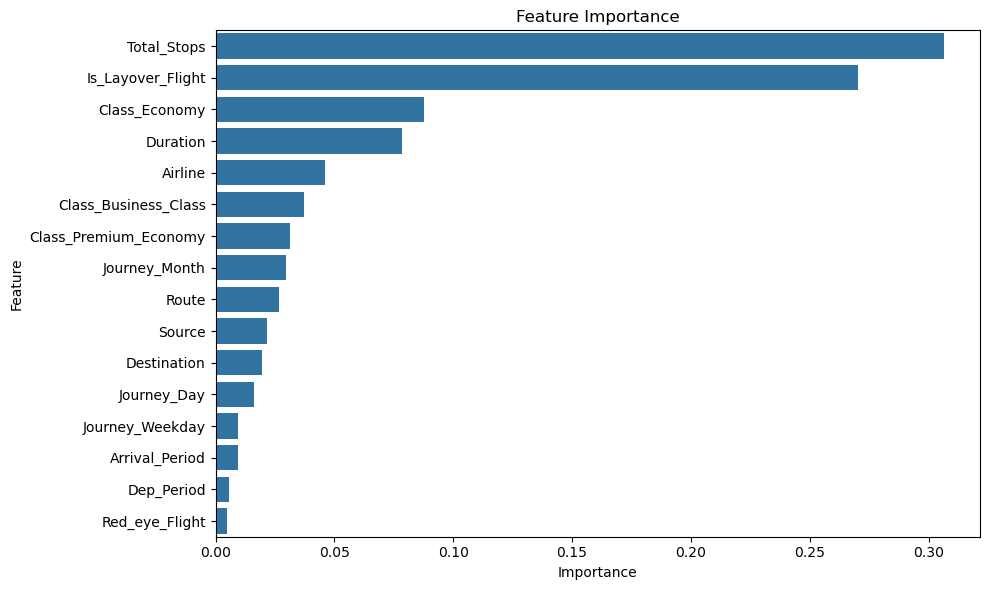

In [83]:
# Extract feature importances
importances = xgb1.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## CHALLENGES FACED:

### 1.Data Cleaning
* Data cleaning was the major challenge faced in this project.
* Data was corrupted.
* There were errors in almost every columns.
* It was harder to fix each and every one.
* There were many logically incorrect and impossible things in the data.

### 2.Less and imbalanced Features
* There is a lack of important features.
* Lots of features that could have helped to improve the performance is not available in the data.
* Features like date of the ticket booking,type of the seats is not available in the data.
* Features like 'Class' were created based on common logics.
* Additional information column was mostly empty.
* Also data is only available on 4 months of a particular year.
* Count of unique values in each column are not balanced.
* For eg,some of the routes,airlines etc. have high majority whereas the other's counts were very less.

### 3.Old Data
* This dataset contains only information on some of the domestic flights in 2019,which cannot be taken as an ideal method to predict future prices.
* Some of the airlines doesn't even exist today,it was harder to find out the price ranges of those flights.

## Predict Price on a new data

In [84]:
# New data sample (dummy example)
new_data = pd.DataFrame([{
    'Airline': 3,                # encoded value for IndiGo
    'Source': 2,                 # Delhi
    'Destination': 1,            # Cochin
    'Route': 3,            
    'Duration': 195,
    'Total_Stops': 0,
    'Journey_Day': 22,
    'Journey_Month': 5,
    'Journey_Weekday':3,
    'Is_Layover_Flight': 0,
    'Red_eye_Flight': 0,
    'Dep_Period':1,
    'Arrival_Period':2,
    'Class_Business_Class': 1,
    'Class_Economy': 0,
    'Class_Premium_Economy':0}])

In [85]:
prediction = xgb1.predict(new_data)
pred= np.exp(prediction)
print("Predicted price:", pred[0])

Predicted price: 13171.382
